In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
cab = pd.read_csv('cab_rides.csv')


In [3]:
cab

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL
...,...,...,...,...,...,...,...,...,...,...
693066,1.00,Uber,1543708385534,North End,West End,13.0,1.0,616d3611-1820-450a-9845-a9ff304a4842,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL
693067,1.00,Uber,1543708385534,North End,West End,9.5,1.0,633a3fc3-1f86-4b9e-9d48-2b7132112341,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX
693068,1.00,Uber,1543708385534,North End,West End,NaN,1.0,64d451d0-639f-47a4-9b7c-6fd92fbd264f,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi
693069,1.00,Uber,1543708385534,North End,West End,27.0,1.0,727e5f07-a96b-4ad1-a2c7-9abc3ad55b4e,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV


In [4]:
weather = pd.read_csv('weather.csv')

In [5]:
weather

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.00,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.00,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.00,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.00,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.00,1012.14,0.1786,1545003901,0.75,11.49
...,...,...,...,...,...,...,...,...
6271,44.72,North Station,0.89,1000.69,NaN,1543819974,0.96,1.52
6272,44.85,Northeastern University,0.88,1000.71,NaN,1543819974,0.96,1.54
6273,44.82,South Station,0.89,1000.70,NaN,1543819974,0.96,1.54
6274,44.78,Theatre District,0.89,1000.70,NaN,1543819974,0.96,1.54


If there are some rides where the price is missing, I remove those observations.

In [6]:
cab.isna().sum()

distance                0
cab_type                0
time_stamp              0
destination             0
source                  0
price               55095
surge_multiplier        0
id                      0
product_id              0
name                    0
dtype: int64

In [7]:
cab = cab.dropna().reset_index()

## Adding the ``base_price``

We have the surge multiplier and the final price. Therefore, we can also determine the ``base_price`` based on these two.

In [8]:
cab['base_price'] = cab['price'] / cab['surge_multiplier']

### Adding the Date as a New Feature

In [9]:
cab['time'] = pd.to_datetime(cab['time_stamp'], unit='ms')
weather['time'] = pd.to_datetime(weather['time_stamp'], unit='s')

## Merging Two DataFrames

Since in the dataframe `cab` will only have information about rides, we need to use the data from dataframe ``weather`` to include additional information about the weather. 

In [17]:
# Convert timestamps to datetime
cab['datetime'] = pd.to_datetime(cab['time_stamp'] / 1000, unit='s')
weather['datetime'] = pd.to_datetime(weather['time_stamp'], unit='s')

# Extract date and location for merging
cab['merge_date'] = cab['datetime'].dt.date
cab['merge_location'] = cab['source']

weather['merge_date'] = weather['datetime'].dt.date
weather['merge_location'] = weather['location']

# Aggregate weather data at location-day level
weather_daily = (
    weather.groupby(['merge_location', 'merge_date'])
    .agg({
        'temp': 'mean',
        'rain': 'mean',
        'humidity': 'mean',
        'wind': 'mean',
        'pressure': 'mean',
        'clouds': 'mean'
    })
    .reset_index()
)

# Merge weather data with cab data
merged = pd.merge(
    cab,
    weather_daily,
    on=['merge_location', 'merge_date'],
    how='left'
)

merged['rain'].fillna(0,inplace=True)


In [20]:
merged['month'] = merged['time'].dt.month
merged['hour'] = merged['time'].dt.hour


In [21]:
merged

,index,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,...,merge_date,merge_location,temp,rain,humidity,wind,pressure,clouds,month,hour
0,0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,...,2018-12-16,Haymarket Square,41.034167,0.044817,0.735417,8.290417,1020.190833,0.691667,12,9
1,1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,...,2018-11-27,Haymarket Square,43.354561,0.116542,0.864211,10.154386,995.805965,0.897895,11,2
2,2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,...,2018-11-28,Haymarket Square,37.106962,0.002100,0.731899,7.854937,992.194051,0.533038,11,1
3,3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,...,2018-11-30,Haymarket Square,35.638400,0.000000,0.712400,3.796800,1015.536800,0.290000,11,4
4,4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,...,2018-11-29,Haymarket Square,38.865469,0.002120,0.672500,10.221406,1000.906562,0.533750,11,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637971,693065,1.00,Uber,1543708385534,North End,West End,9.5,1.0,353e6566-b272-479e-a9c6-98bd6cb23f25,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,...,2018-12-01,West End,36.657778,0.000200,0.705556,3.431852,1020.903333,0.648889,12,23
637972,693066,1.00,Uber,1543708385534,North End,West End,13.0,1.0,616d3611-1820-450a-9845-a9ff304a4842,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,...,2018-12-01,West End,36.657778,0.000200,0.705556,3.431852,1020.903333,0.648889,12,23
637973,693067,1.00,Uber,1543708385534,North End,West End,9.5,1.0,633a3fc3-1f86-4b9e-9d48-2b7132112341,55c66225-fbe7-4fd5-9072-eab1ece5e23e,...,2018-12-01,West End,36.657778,0.000200,0.705556,3.431852,1020.903333,0.648889,12,23
637974,693069,1.00,Uber,1543708385534,North End,West End,27.0,1.0,727e5f07-a96b-4ad1-a2c7-9abc3ad55b4e,6d318bcc-22a3-4af6-bddd-b409bfce1546,...,2018-12-01,West End,36.657778,0.000200,0.705556,3.431852,1020.903333,0.648889,12,23


In [22]:
merged.columns

Index(['index', 'distance', 'cab_type', 'time_stamp', 'destination', 'source',
       'price', 'surge_multiplier', 'id', 'product_id', 'name', 'base_price',
       'time', 'datetime', 'merge_date', 'merge_location', 'temp', 'rain',
       'humidity', 'wind', 'pressure', 'clouds', 'month', 'hour'],
      dtype='object')

In [23]:
features_to_drop = ['index', 'time_stamp', 'id', 'product_id', 'time', 'datetime', 'merge_date', 'merge_location']

In [24]:
df = merged.drop(columns=features_to_drop)

In [25]:
df.isna().sum()

distance            0
cab_type            0
destination         0
source              0
price               0
surge_multiplier    0
name                0
base_price          0
temp                0
rain                0
humidity            0
wind                0
pressure            0
clouds              0
month               0
hour                0
dtype: int64

In [26]:
# To clean memory, I remove the following dataframes
del merged
del cab
del weather

## Standardizing Vehicle Types Across Uber and Lyft

Uber and Lyft use different names for similar types of vehicles, even though the actual service level is often the same. To make the data easier to compare, I grouped the vehicle names into common categories. This way, I can compare pricing and patterns across both platforms more fairly.

The grouping is as follows:

- **Standard**: Regular 4-seat rides (``Lyft``, ``UberX``)

- **XL**: Larger vehicles for groups (``Lyft XL``, ``UberXL``)

- **Shared**: Rides with other passengers (``Shared``, ``UberPool``)

- **Premium**: Luxury rides with upscale vehicles (``Lux Black``, ``Black``)

- **Premium XL**: Larger luxury rides (``Lux Black XL``, ``Black SUV``)

I excluded ``Lux`` and ``WAV`` as they either don’t have a clear counterpart or are less commonly available.

In [27]:
vehicle_type_map = {
    'Lyft': 'Standard',
    'UberX': 'Standard',

    'Lyft XL': 'XL',
    'UberXL': 'XL',

    'Shared': 'Shared',
    'UberPool': 'Shared',

    'Lux Black': 'Premium',
    'Black': 'Premium',

    'Lux Black XL': 'Premium XL',
    'Black SUV': 'Premium XL',
}

df['vehicle_type'] = df['name'].map(vehicle_type_map)
df = df[~df['name'].isin(['Lux', 'WAV'])].copy()

In [28]:
df.columns

Index(['distance', 'cab_type', 'destination', 'source', 'price',
       'surge_multiplier', 'name', 'base_price', 'temp', 'rain', 'humidity',
       'wind', 'pressure', 'clouds', 'month', 'hour', 'vehicle_type'],
      dtype='object')

# 1.	Does Uber systematically charge more than Lyft for the same trip conditions?

This part of the project aims to answer whether **Uber consistently charges more than Lyft for similar trips**. To do this, I control for trip-related and environmental factors like distance, pickup and drop-off locations, time of day, weather conditions (e.g., temperature, rain), and other relevant variables that may affect price.

By comparing prices between **Uber and Lyft rides with the same conditions**, I isolate the impact of the **platform** (``cab_type``) on the fare. This setup helps assess whether one company systematically prices higher than the other, beyond normal variation due to demand, route, or conditions. The analysis is built to reflect real-world fairness in price comparisons and can inform both consumer behavior and platform strategy.

## Distribution of Price

Based on the following graph, we can observe that price distribution is not symmetric and it is **right-skewed**. Therefore, using OLS is not a good choice. Instead when I use ``log(price)``, we can observe that the ``log(price)`` looks like a Normal distribution, and we can use OLS approach. It should be noted that when I use log(price) as the target variable, the coefficient of the treatment variable indicates the **percentage difference in price** between the two groups, approximately interpreted as $100 \times [\exp(\beta)-1]$.

<Axes: xlabel='price', ylabel='Count'>

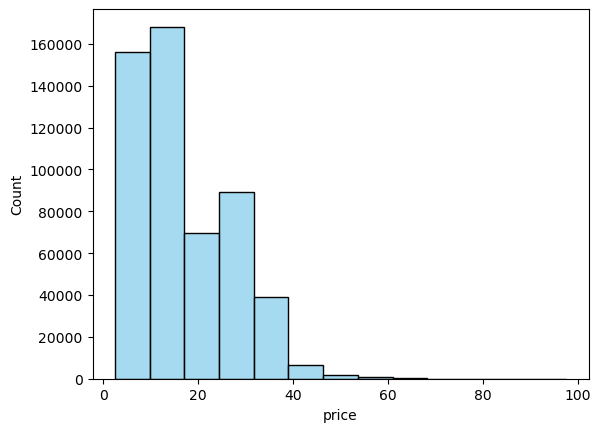

In [29]:
sns.histplot(df['price'], kde=False, bins=13, color='skyblue')

<Axes: xlabel='price', ylabel='Count'>

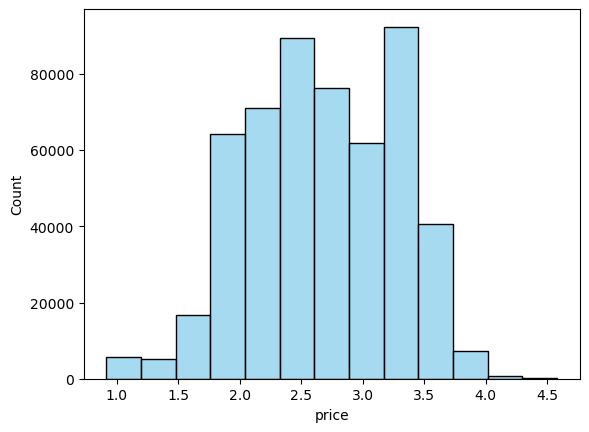

In [30]:
sns.histplot(np.log(df['price']), kde=False, bins=13, color='skyblue')

## Price Charged by Uber and Lyft Over Time

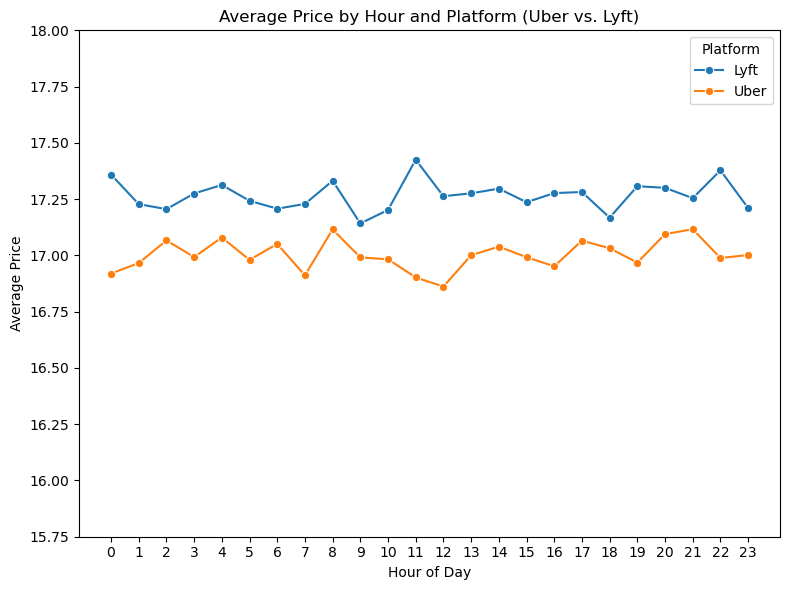

In [33]:
# Compute average price by hour and cab_type
avg_price_by_hour = df.groupby(['hour', 'cab_type'])['price'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.lineplot(data=avg_price_by_hour, x='hour', y='price', hue='cab_type', marker='o')

plt.title('Average Price by Hour and Platform (Uber vs. Lyft)')
plt.xlabel('Hour of Day')
plt.ylabel('Average Price')
plt.xticks(range(0, 24))
plt.legend(title='Platform')
plt.ylim(15.75,18)
plt.tight_layout()
plt.show()


## 1.1 Baseline Model: Average Price Comparison Between Uber and Lyft 

### 1.1.1 Including All Variables

This initial model estimates the average difference in pricing between Uber and Lyft without accounting for interactions or subgroup variations. By including only the main effects of observed trip conditions (e.g., distance, time, location, weather), the model assesses whether Uber systematically charges more than Lyft under comparable conditions. This serves as a foundational benchmark for identifying any consistent price premium associated with either platform.

In this first model, I include all variables to predict the price and do not include any interaction between variables. Based on the results, ``hour`` is not a significant variable in determining the price. Also, ``temp``, ``humidity``, ``wind``, ``pressure`` and ``clouds`` are insignificant variables.

In [36]:
df['log_price'] = np.log(df['price'])


formula = (
    "log_price ~ C(cab_type) + C(vehicle_type) + distance + C(source) + C(destination) + C(hour) + temp + rain + humidity + wind + pressure + clouds"
)



model = smf.ols(formula, data=df).fit()
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                 9.250e+04
Date:                Wed, 28 May 2025   Prob (F-statistic):               0.00
Time:                        00:36:16   Log-Likelihood:             1.5218e+05
No. Observations:              531645   AIC:                        -3.043e+05
Df Residuals:                  531588   BIC:                        -3.036e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

### 1.1.2 Including Significant Variables


The regression model estimates the log of ride prices based on platform (``cab_type``), vehicle type, trip distance, pickup and drop-off locations, and rain conditions. The key variable of interest, ``cab_type``, shows that **Uber charges significantly more than Lyft** for rides with similar conditions. Specifically, the coefficient for ``C(cab_type)[T.Uber]`` is **0.0573**, indicating that, holding all other factors constant, Uber prices are approximately ``5.9%`` higher than Lyft prices on average (**exp(0.0573) ≈ 1.059**). This effect is statistically significant with a p-value close to zero.

The model explains about **90.7%** of the variation in log ride prices, suggesting that ``distance``, ``vehicle type``, and location are strong predictors of price. Other variables, such as ``distance`` and ``vehicle_type``, also have large and meaningful effects, while ``rain`` shows a small but statistically significant negative effect.

These results support the conclusion that **Uber consistently applies higher pricing than Lyft**, even after controlling for trip characteristics and external factors.

In [37]:
df['log_price'] = np.log(df['price'])


formula = (
    "log_price ~ C(cab_type) + C(vehicle_type) + distance + C(source) + C(destination) + rain"
)



model = smf.ols(formula, data=df).fit()
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                 1.850e+05
Date:                Wed, 28 May 2025   Prob (F-statistic):               0.00
Time:                        00:40:48   Log-Likelihood:             1.5217e+05
No. Observations:              531645   AIC:                        -3.043e+05
Df Residuals:                  531616   BIC:                        -3.040e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

## 1.2 Model with Interaction Effects: Exploring Price Differences Across Vehicle Types

This model investigates whether Uber systematically charges more than Lyft by including not only the platform (``cab_type``) but also the **interaction between platform and ride type** (``vehicle_type``). This allows us to see whether the **price difference between Uber and Lyft depends on the kind of ride** — for example, Shared, Standard, XL, or Premium.

**Note**: From the way categorical variables are encoded, **Premium** is the **reference category**.

In the previous model (without interaction), Uber was estimated to be about 5.9% more expensive than Lyft on average. However, once we include interactions, the interpretation of the ``cab_type`` coefficient changes.

- The coefficient for ``C(cab_type)[T.Uber]`` is now **−0.1095**, meaning that for the **Premium vehicle type**, Uber is about **10.95% cheaper** than Lyft.

- However, this **does not reflect the overall average** difference anymore. Instead, it shows the difference **only for that specific base ride type**.

To understand how Uber and Lyft compare across **real ride types**, we look at the **interaction terms**:

1.
   **Premium (Reference category)**

&emsp; &emsp; **Lyft Premium**: Intercept

&emsp; &emsp; **Uber Premium**: Intercept + (−0.1095)

&emsp;&emsp; → Uber is **~10.4%** cheaper than Lyft Premium

2. **Premium XL**

&emsp; &emsp; **Lyft**: Intercept + 0.3518

&emsp;&emsp;**Uber**: Intercept − 0.1095 + 0.3518 + 0.0524 = Intercept + 0.2947

&emsp; &emsp;→ Uber is **~5.5% cheaper** than Lyft for Premium XL


3. **XL**
   
&emsp;&emsp; **Lyft**: Intercept − 0.4153

&emsp;&emsp;**Uber**: Intercept − 0.1095 − 0.4153 + 0.1357 = Intercept − 0.3891

&emsp;&emsp;→ Uber is **~2.6% more expensive** than Lyft XL


4. **Standard**
   
&emsp;&emsp; **Lyft**: Intercept − 0.8718

&emsp;&emsp;**Uber**: Intercept − 0.1095 − 0.8718 + 0.1280 = Intercept − 0.8533

&emsp;&emsp;→ Uber is **~1.9% more expensive** than Lyft Standard


5. **Shared**
   
&emsp;&emsp;**Lyft**: Intercept − 1.3703

&emsp;&emsp;**Uber**: Intercept − 0.1095 − 1.3703 + 0.5182 = Intercept − 0.9616

&emsp; &emsp; → **Uber** is **~40.1% more expensive** than Lyft Shared



| Ride Type  | Lyft Price (baseline) | Uber Price (vs. Lyft)    | % Difference (Uber vs. Lyft) |
| ---------- | --------------------- | ------------------------ | ---------------------------- |
| Premium    | Reference             | 10.4% **cheaper**        |                              |
| Premium XL | +0.3518               | 5.5% **cheaper**         |                              |
| XL         | −0.4153               | 2.6% **more expensive**  |                              |
| Standard   | −0.8718               | 1.9% **more expensive**  |                              |
| Shared     | −1.3703               | 40.1% **more expensive** |                              |



In [28]:
df['log_price'] = np.log(df['price'])


formula = (
    "log_price ~ C(cab_type) * C(vehicle_type) + distance + C(source) + C(destination) + rain"
)



model = smf.ols(formula, data=df).fit()
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                 2.220e+05
Date:                Tue, 27 May 2025   Prob (F-statistic):               0.00
Time:                        00:44:47   Log-Likelihood:             2.2937e+05
No. Observations:              531645   AIC:                        -4.587e+05
Df Residuals:                  531612   BIC:                        -4.583e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

## 1.3 Model with Interaction Effects: Exploring Price Differences by Platform and Distance

In this section, the interest is whether **Uber systematically charges more than Lyft** and **how that difference varies with trip distance**. To test this, we included an interaction term between ``cab_type`` and ``distance``.

- The **main effect** of ``cab_type = Uber`` is **+0.1440** (p < 0.001), suggesting that for **very short trips (i.e., distance ≈ 0)**, Uber is about **15.5% more expensive than Lyft**.

- The **interaction term between Uber and distance** is **−0.0396** (p < 0.001), indicating that **Uber’s price increases less steeply with distance** compared to Lyft.

- The main effect of ``distance`` is **+0.1963**, which reflects how **Lyft's price increases by about 21.7% for every unit increase in distance** (exp(0.1963) ≈ 1.217).

-  For Uber, the distance slope becomes:

  &emsp; &emsp; 0.1963 (base) − 0.0396 (interaction) = **0.1567**

  &emsp; &emsp; This means Uber’s price increases by about **16.9% per unit of distance** (exp(0.1567) ≈ 1.169).

These results reveal an important pattern:

- **Uber is more expensive than Lyft for short trips**, but

- **As distance increases, the price difference narrows**, and may even **reverse** for long trips.

In [31]:
df['log_price'] = np.log(df['price'])


formula = (
    "log_price ~ C(cab_type)*distance + C(vehicle_type)  + C(source) + C(destination) + rain"
)



model = smf.ols(formula, data=df).fit()
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                 1.816e+05
Date:                Tue, 27 May 2025   Prob (F-statistic):               0.00
Time:                        01:26:30   Log-Likelihood:             1.5614e+05
No. Observations:              531645   AIC:                        -3.122e+05
Df Residuals:                  531615   BIC:                        -3.119e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

## 1.4 Model with Interaction Effects: Evaluating Price Sensitivity to Rain Across Platforms

In this model, we examine the effect of ``rain`` on **ride prices** across ride-hailing platforms, focusing on whether Uber and Lyft respond differently to rainy conditions.

- The **main effect** of ``rain`` is **−0.0411** (p < 0.001).

&emsp; &emsp; This suggests that during rain, Lyft’s prices decrease by about 4% (since $e^{-0.0411}≈0.9598$) compared to dry conditions, holding other factors constant.

- The interaction term, ``C(cab_type)[T.Uber]:rain``, is **+0.0409** (p = 0.006), meaning that:

&emsp; &emsp; **Uber’s price during rain is ~4.2% higher than Lyft’s**, relative to their respective dry-weather prices.

- Combining both terms:
 
- Lyft's estimated price effect during rain: −4.1%

- Uber’s estimated price effect during rain:

&emsp; &emsp; **−4.1%+4.09%= ~0% — i.e., Uber’s prices are unaffected by rain**

| Platform | Price Impact During Rain                |
| -------- | --------------------------------------- |
| **Lyft** | Prices drop \~4%                        |
| **Uber** | No significant change                   |
| **Gap**  | Uber is \~4% more expensive during rain |

This indicates that Uber holds prices steady during rain, while Lyft reduces its prices. The result is a widening of the Uber–Lyft price gap in rainy weather.

In [32]:
df['log_price'] = np.log(df['price'])


formula = (
    "log_price ~ C(cab_type)*rain + C(vehicle_type) + distance + C(source) + C(destination) "
)



model = smf.ols(formula, data=df).fit()
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                 1.786e+05
Date:                Tue, 27 May 2025   Prob (F-statistic):               0.00
Time:                        01:28:17   Log-Likelihood:             1.5213e+05
No. Observations:              531645   AIC:                        -3.042e+05
Df Residuals:                  531615   BIC:                        -3.039e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

# 2. Are customers more likely to choose upper-tier rides (e.g., Premium, XL, Premium XL) during surge pricing events?

Surge pricing increases the cost of rides. You might think that when prices go up, people would try to save money and choose cheaper ride types. But in reality, during surge, lower-tier rides (like Shared or Standard) are sometimes unavailable, or the price gap between ride types becomes smaller. This question helps us understand how customer behavior changes during surge: do they still try to save money, or do they end up choosing more expensive rides?

## Interpretation of Results

We ran a logistic regression model to check if surge pricing makes people more likely to choose upper-tier rides. After controlling for platform (Uber or Lyft), distance, time of day, and weather, we found the following:

- The coefficient for ``surge_active`` is **0.7372**, and it's **statistically significant**.

- This means that when surge pricing is active, the **odds of a customer choosing an upper-tier ride are about 2.1 times higher** than when surge is not active.

In other words:

- **People are much more likely to choose Premium or XL rides during surge.**

This could be because:

- Shared or Standard rides are **not available** or have long wait times during surge

- The **price difference** between ride types becomes smaller during surge

- The app might show higher-tier options more clearly

So, while surge makes rides more expensive, it also seems to **push people toward more expensive ride types** — not away from them.

In [44]:
upper_tiers = ['Premium', 'Premium XL', 'XL']
df['choice_upper_tier'] = df['vehicle_type'].isin(upper_tiers).astype(int)


In [45]:
formula = (
    "choice_upper_tier ~ surge_active + C(cab_type) + distance + hour + "
    "rain + temp + humidity"
)

model = smf.logit(formula=formula, data=df).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.671328
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      choice_upper_tier   No. Observations:               531645
Model:                          Logit   Df Residuals:                   531637
Method:                           MLE   Df Model:                            7
Date:                Tue, 27 May 2025   Pseudo R-squ.:                0.002496
Time:                        02:12:23   Log-Likelihood:            -3.5691e+05
converged:                       True   LL-Null:                   -3.5780e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.3678      0.025     14.995      0.000       0.320       0.416
C(

In [46]:
odds_ratio = np.exp(model.params['surge_active'])
print(f"Odds Ratio for surge_active: {odds_ratio:.3f}")

Odds Ratio for surge_active: 2.090
